In [4]:
import pandas as pd
import numpy as np
import  matplotlib.pyplot as plt
import seaborn as sns


In [5]:
train_data = pd.read_csv('/Users/annikaseo-yeonkim/Desktop/아무거나/kaggle/titanic/train.csv')
test_data = pd.read_csv('/Users/annikaseo-yeonkim/Desktop/아무거나/kaggle/titanic/test.csv')
train_df_len = len(train_data)
train_df = pd.concat([train_data,test_data],axis = 0).reset_index(drop = True)

In [142]:
median_age_by_pclass = train_df.groupby('Pclass')['Age'].median()
# print(median_age_by_pclass)

def fill_age(row):
    if pd.isnull(row['Age']):
        return median_age_by_pclass[row['Pclass']]
    else:
        return row['Age']
    
train_df['Age'] = train_df.apply(fill_age, axis=1)

In [15]:
train_df['Deck'] = train_df['Cabin'].str.slice(0,1)
deck_distribution = train_df['Deck'].value_counts(dropna = False)
clean_distribution = train_df['Deck'].value_counts(dropna = True)

print(train_df.groupby('Deck')['Fare'].median())
# correlation_coefficient3 = train_df['Deck'].corr(train_df['Pclass'])
# print(train_df.groupby('Survived')['Age'].median())

print(train_df.groupby('Deck')['Pclass'].value_counts()) #Cabin C had the most 1st class passengers 

train_df['title'] = train_df.Name.str.extract('\, ([A-Z][^ ]*\.)',expand=False) #title deck

#print(train_df['Fare'].min()) # there are zero values in the dataset
#print((train_df.Fare == 0).sum()) # 17 zero values 
train_df.Fare = train_df.Fare.replace(0,np.NaN) # replace 0 with NaN
# print((train_df.Fare == 0).sum())

#now fill in the Fare column
train_df['Fare_clean'] = train_df.Fare.dropna()
#print(train_df['Fare_clean'])
correlation_coefficient3 = train_df['Fare_clean'].corr(train_df['Pclass']) #correlation_coefficient3 = -0.5694
median_fare_by_pclass = train_df.groupby('Pclass')['Fare'].median()
# print(median_fare_by_pclass)


Deck
A    35.50000
B    84.38335
C    86.28960
D    52.55420
E    53.10000
F    13.00000
G    16.70000
T    35.50000
Name: Fare, dtype: float64
Deck  Pclass
A     1         22
B     1         65
C     1         94
D     1         40
      2          6
E     1         34
      2          4
      3          3
F     2         13
      3          8
G     3          5
T     1          1
Name: count, dtype: int64
Pclass
1    61.3792
2    15.0500
3     8.0500
Name: Fare, dtype: float64


In [20]:
def fill_fare(row):
    if pd.isnull(row['Fare']):
        return median_fare_by_pclass[row['Pclass']]
    else:
        return row['Fare']
    
train_df['Fare'] = train_df.apply(fill_fare, axis=1)
# fare_distribution = train_df['Fare'].value_counts(dropna = False)



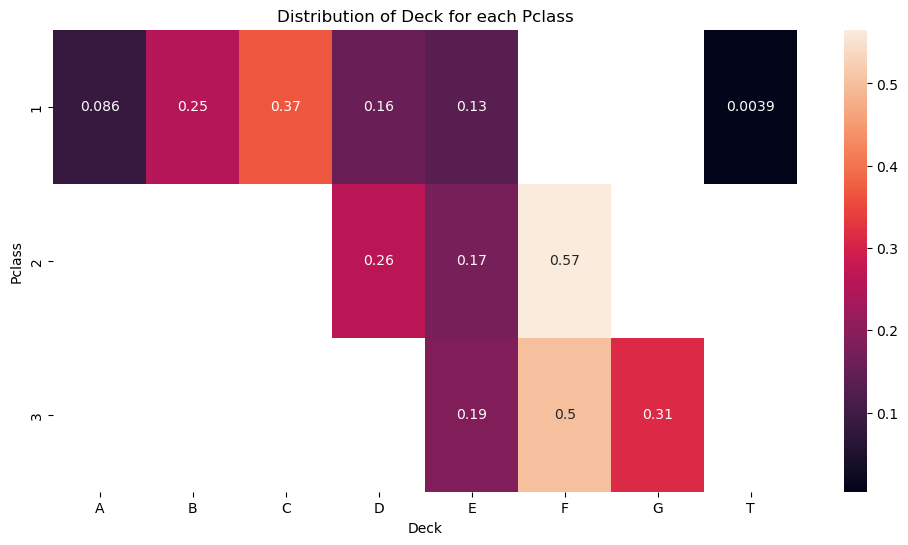

In [54]:
# deck column
train_df = train_df.dropna(subset=['Deck', 'Pclass'])

# Group by Cabin and calculate the distribution of Pclass
cabin_pclass_distribution = train_df.groupby('Pclass')['Deck'].value_counts(normalize=True).unstack()

# Plot the distribution
plt.figure(figsize=(12, 6))
sns.heatmap(cabin_pclass_distribution, annot = True)
plt.title('Distribution of Deck for each Pclass')
plt.xlabel('Deck')
plt.ylabel('Pclass')
plt.show()

In [61]:
train_df['Deck'] = train_df.groupby('Pclass')['Deck'].transform(lambda x: x.fillna(x.mode().loc[0])) # used chatgpt
# print(sum(train_df['Deck'].isnull())) --> validated the results (the 'Deck' column is now filled)

In [65]:
print(sum(train_df['Survived'].isnull())) # missing 418 values in the 'Survived' column

418


In [99]:
sex_encoded = pd.get_dummies(train_df['Sex'], prefix='sex')

# Concatenate the original DataFrame with the new one-hot encoded variable
df_encoded = pd.concat([train_df, sex_encoded], axis=1)


        Survived
Pclass          
1       0.629630
2       0.472826
3       0.242363
Deck  Survived
A     0.0           8
      1.0           7
B     1.0          35
      0.0          12
C     1.0          54
      0.0          45
D     1.0          25
      0.0           8
E     1.0          24
      0.0           8
F     0.0         465
      1.0         195
G     0.0           2
      1.0           2
T     0.0           1
Name: count, dtype: int64


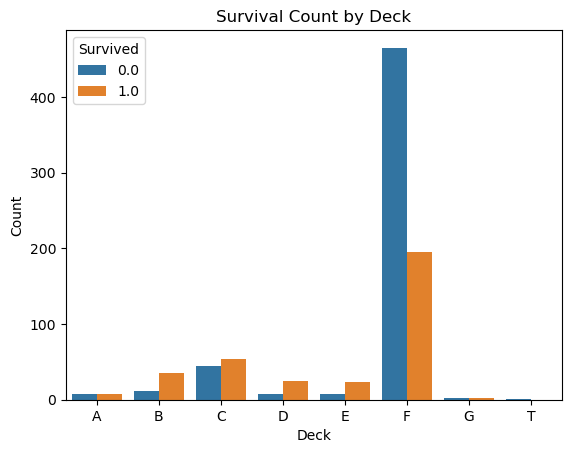

In [118]:
print(train_df[['Pclass','Survived']].groupby('Pclass').mean()) 
corr = train_df['Pclass'].corr(train_df['Survived']) # corr = -0.338
corr2 = train_df['Age'].corr(train_df['Survived']) # corr2 = -0.077 
corr3 = train_df['Fare'].corr(train_df['Survived']) # corr3 = 0.25
corr_sex_survived = df_encoded[['sex_male', 'sex_female']].corrwith(df_encoded['Survived']) #asked chatgpt and got sex_male = -0.54, sex_female = 0.54
print(train_df.groupby('Deck')['Survived'].value_counts())
# sns.barplot(train_df.groupby('Deck')['Survived']) 
# plt.show()

grouped_counts = train_df.groupby(['Deck', 'Survived']).size().reset_index(name='Count')

# Plot the grouped counts using seaborn #asked my good friend ChatGpt
sns.barplot(x='Deck', y='Count', hue='Survived', data=grouped_counts)
plt.title('Survival Count by Deck')
plt.xlabel('Deck')
plt.ylabel('Count')
plt.show()

In [139]:
# Deck F passengers mostly died, more females survived than males, 1st class passengers mostly survived --> will use these correlations to fill out the 'survived' column
sum =0
count_f = (train_df['Deck'] == "F").sum()

# Check if 'Deck' is "F" and 'Survived' is NaN
condition_met = (train_df['Deck'] == "F") & (train_df['Survived'].isna())

for index, row in train_df.iterrows():
    # Check if 'Deck' is "F" and 'Survived' is NaN for the current passenger 
    if row['Deck'] == "F" and pd.isna(row['Survived']) and row['Sex'] == "Female":
        # If the condition is met, update 'Survived' to 1 for the current passenger
        train_df.at[index, 'Survived'] = 1





In [168]:
for index, row in train_df.iterrows():
    # Check if 'Pclass' is 1 and 'Survived' is NaN for the current passenger 
    if pd.isna(row['Survived']) and row['Pclass'] == 1:
        # If the condition is met, update 'Survived' to 1 for the current passenger
        train_df.at[index, 'Survived'] = 1

# print(train_df['Survived'])
# print(train_df['Survived'].isnull().sum()) --> have three more cells to fill in

for index, row in train_df.iterrows():
    if pd.isna(row['Survived']):
        print(index,row)
        print()



1296 PassengerId                                            1297
Survived                                                NaN
Pclass                                                    2
Name           Nourney, Mr. Alfred (Baron von Drachstedt")"
Sex                                                    male
Age                                                    20.0
SibSp                                                     0
Parch                                                     0
Ticket                                        SC/PARIS 2166
Fare                                                13.8625
Cabin                                                   D38
Embarked                                                  C
Deck                                                      D
title                                                   Mr.
Fare_clean                                          13.8625
deck_clean                                                D
Name: 1296, dtype: object



In [185]:
import requests
import pandas as pd

# print(train_df['Survived'].isnull().sum()) - three passengers don't meet some but not all of the conditions listed above (shall deal with them on a case by case basis)
for index, row in train_df.iterrows():
    if "Sandstrom" in row['Name']: #Passenger Beatrice Irene Sandstrom -  mom and sister survived
        # print(row['Name'],row['PassengerId'])
        train_df.at[index, 'Survived'] = 1
    
        print(row['Name'],row['Survived'])
    
    if "Malachard" in row['Name']: #Noel Malachard: no siblings or spouse, 2nd class passenger, male, 29 y/o --> probably didn't survive
        # print(row['Name'],row['Survived'])
        train_df.at[index, 'Survived'] = 0

        print(row['Name'],row['Survived'])
    
    if "Nourney" in row['Name']: # Alfred Nourney: no siblings or spouse, 2nd class passenger, male, 20 y/o, cabin D  --> very low chances of survival
        # print(row['Name'],row['Survived'])
        train_df.at[index, 'Survived'] = 0

        print(row['Name'],row['Survived'])
    

# print(train_df['Survived'].isnull().sum())

# print(train_df['PassengerId'],train_df['Survived'])

survivors = pd.concat([train_df['PassengerId'],train_df['Survived']],axis =1)
file_name = "titanic_survived"
survivors.to_csv(file_name, index=False)
    

Sandstrom, Miss. Marguerite Rut 11
Sandstrom, Miss. Marguerite Rut 1.0
Sandstrom, Mrs. Hjalmar (Agnes Charlotta Bengtsson) 395
Sandstrom, Mrs. Hjalmar (Agnes Charlotta Bengtsson) 1.0
Sandstrom, Miss. Beatrice Irene 1009
Sandstrom, Miss. Beatrice Irene 1.0
Malachard, Mr. Noel 0.0
Nourney, Mr. Alfred (Baron von Drachstedt")" 0.0
